In [1]:
%cd ..

/Users/clement/FactorExe


/Users/clement/.pyenv/versions/3.10.11/envs/factorexe/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import functools

import jax
import jax.numpy as jnp
import numpy as np

from c_vpr.cycle import Cycle

In [3]:
env = Cycle(input_length=40)
keys = jax.random.split(jax.random.PRNGKey(0), 8)
examples, cot, targets = jax.vmap(functools.partial(env.sample_n_hops, num_hops=2, return_target=True, return_cot=True))(keys)

In [4]:
for example, cot_, target in zip(examples, cot, targets):
    print(example, cot_, target, "\n")

[ 5 37 34 16 21 14  8 32 17 23 31  3 20 19 35 26 39 38 27 29  2 10 24 12
  0 30 28 11  9 36  1 18  6  7 33 25 15 13  4 22] [ 5 14 35] 35 

[14  3 12 39  1 38 19 13  6 15 23 18 25 22 24 34 28 33 32 35 11  4 16 26
  9 20  5 17  8 10 31  0 30 29 21 37 27  2  7 36] [14 24  9] 9 

[25 11 28 19 31 26 34 37  7 36 15 24 14  9 16 20 21  2 10 33  6  4 35 38
  8  5 13 18  1 17  0  3 29 32 39 12 27 23 30 22] [25  5 26] 26 

[12 20 25 39 24  9 27 23 33 28  6 37 10  8  3 26 38  2 15  4 34 36 14 13
 35 21 31 19 32 17 29 16  7 30  5 18 22  0  1 11] [12 10  6] 6 

[37 24  6  7 35 11 31 16 27 33  0 22  1 30  4 13  9 38  3 32 26  8 34 21
 29 14 18 20 17 25 36 15 39 28 12 23 19  2 10  5] [37  2  6] 6 

[37  4 21 34 23 24  0 27  2  6 11 28 13  3 16 29 22 30 12 26 15 18 35 25
 38  9 10  1 33 31 20  8  7 39 32 17  5 19 14 36] [37 19 26] 26 

[11 19 22 38 23  0  1 31 39 36 30 33 24  4 32 35 28 10 21  3 27  5 12 34
  8 29  9  7 18 26 20 15 25  6 17  2 13 14 37 16] [11 33  6] 6 

[15  2 21 12 30 14 26  6  5 27 

In [5]:
targets

Array([35,  9, 26,  6,  6, 26,  6,  4], dtype=int32)

In [6]:
import logging

import wandb

from c_vpr.transformer_utils import TransformerConfig
from c_vpr.old_augmented_transformer import AugmentedTransformer, CoTModuleConfig
from c_vpr.train import Trainer, MODE

def get_model(
    run_name: str,
    checkpoint_version: str = "latest",
    mode: MODE = MODE.SUPERVISED,
    train_num_hops: int | list[int] = 3,
    eval_num_hops: int | list[int] | None = None,
    seq_length: int = 10,
    encoder_num_heads: int = 6,
    encoder_num_layers: int = 1,
    encoder_num_repeat_model: int = 1,
    cot_module: bool = False,
    cot_seq_length: int = 3,
    cot_num_heads: int = 6,
    cot_num_layers: int = 1,
    cot_num_repeat_model: int = 1,
    decoder_num_heads: int = 6,
    decoder_num_layers: int = 1,
    decoder_num_repeat_model: int = 1,
    emb_dim: int = 384,
    mlp_dim_factor: float = 4,
    all_dropouts_rate: float = 0.0,
    cot_loss_weight_mixing: float = 1.0,
    cot_stop_gradient_encoder: bool = True,
    decode_from_sampled_cot_tokens: bool = False,
    learning_rate: float = 3e-4,
    batch_size: int = 512,
    eval_size: int = 500,
):
    encoder_config = TransformerConfig(
        vocab_size=seq_length,
        output_vocab_size=None,
        emb_dim=emb_dim,
        num_heads=encoder_num_heads,
        num_layers=encoder_num_layers,
        num_repeat_model=encoder_num_repeat_model,
        mlp_dim_factor=mlp_dim_factor,
        max_len=seq_length,
        dropout_rate=all_dropouts_rate,
        attention_dropout_rate=all_dropouts_rate,
    )
    if cot_module:
        if (
            mode in [MODE.COT, MODE.RL]
            and isinstance(train_num_hops, int)
            and cot_seq_length != train_num_hops
        ):
            logging.warning(
                f"cot_seq_length ({cot_seq_length}) is different from train_num_hops "
                "({train_num_hops}), which means that the chain of thought sequence and "
                "the chain of thoughts labels have different lengths. This is not supported yet."
            )
        cot_module_config = CoTModuleConfig(
            cross_transformer_config=TransformerConfig(
                vocab_size=None,
                output_vocab_size=None,
                emb_dim=emb_dim,
                num_heads=cot_num_heads,
                num_layers=cot_num_layers,
                num_repeat_model=cot_num_repeat_model,
                mlp_dim_factor=mlp_dim_factor,
                max_len=None,
                dropout_rate=all_dropouts_rate,
                attention_dropout_rate=all_dropouts_rate,
            ),
            cot_seq_length=cot_seq_length,
            cot_vocab_size=seq_length,
        )
    else:
        assert mode != MODE.COT, "COT mode requires cot_module to be True"
        cot_module_config = None
    decoder_config = TransformerConfig(
        vocab_size=None,
        output_vocab_size=seq_length,
        emb_dim=emb_dim,
        num_heads=decoder_num_heads,
        num_layers=decoder_num_layers,
        num_repeat_model=decoder_num_repeat_model,
        mlp_dim_factor=mlp_dim_factor,
        max_len=None,
        dropout_rate=all_dropouts_rate,
        attention_dropout_rate=all_dropouts_rate,
    )
    model = AugmentedTransformer(
        encoder_config,
        cot_module_config,
        decoder_config,
    )
    env = Cycle(seq_length)

    print(isinstance(model, AugmentedTransformer))
    trainer = Trainer(
        model,
        env,
        mode,
        train_num_hops,
        eval_num_hops,
        seq_length,
        batch_size,
        eval_size,
        cot_start_token=cot_module_config.cot_vocab_size if cot_module_config else None,
        cot_loss_weight_mixing=cot_loss_weight_mixing,
        cot_stop_gradient_encoder=cot_stop_gradient_encoder,
        decode_from_sampled_cot_tokens=decode_from_sampled_cot_tokens,
    )
    key = jax.random.PRNGKey(0)
    state = trainer.init_train_state(key, learning_rate)
    wandb.init(project="FactorExe")
    state = trainer.load_checkpoint("checkpoint.msgpack", state, run_name, version=checkpoint_version)
    return model, state

model, state = get_model(
    run_name="Cycle 2-40, AT(0, 1, 2) COT",
    checkpoint_version="v2",
    train_num_hops=2,
    eval_num_hops=[1, 2, 3, 4],
    seq_length=40,
    mode=MODE.COT,
    encoder_num_repeat_model=0,
    cot_module=True,
    cot_seq_length=2,
    cot_num_layers=1,
    cot_num_repeat_model=1,
    decoder_num_repeat_model=1,
    decoder_num_layers=2,
    batch_size=256,
)

/Users/clement/.pyenv/versions/3.10.11/envs/factorexe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


INFO:root:Number of parameters: 7,177,344
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: clementbonnet. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact Cycle2-40.AT_0.1.2_COT--checkpoint:v2, 82.15MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.9


In [9]:
env = Cycle(input_length=40)
keys = jax.random.split(jax.random.PRNGKey(0), 1000)
examples, cots, targets = jax.vmap(functools.partial(env.sample_n_hops, num_hops=2, return_target=True, return_cot=True))(keys)
examples[:3], cots[:3], targets[:3]

(Array([[ 5, 23,  7, 15, 33, 29, 20, 28, 24, 25, 18, 14, 17, 34, 31, 12,
         38,  1, 35, 30, 22, 39, 32, 36, 37, 21, 19,  3,  6,  8, 13,  2,
         10,  0, 11,  9, 16, 26,  4, 27],
        [13,  3, 36, 23, 22, 10, 39, 24, 35, 16,  0, 30, 11, 38, 21,  9,
         12,  2, 32, 25,  5,  7, 28, 26, 33,  6, 18, 19, 20, 15, 27, 34,
          8, 31,  1,  4, 14, 29, 37, 17],
        [38, 22, 15, 34, 33, 23, 37, 20, 19, 18, 21, 36,  4,  6, 39, 27,
         12, 16,  7, 30,  5, 29,  8, 31,  2, 17, 35, 25, 11,  0, 28, 24,
         26,  3, 13,  1, 10, 14,  9, 32]], dtype=int32),
 Array([[ 5, 29],
        [13, 38],
        [38,  9]], dtype=int32),
 Array([ 8, 37, 18], dtype=int32))

In [10]:
logits = state.apply_fn(
    {"params": state.params},
    inputs=examples,
    deterministic=True,
)
logits.shape

(1000, 40)

In [11]:
print("Accuracy:", jnp.mean(jnp.argmax(logits, axis=-1) == targets))

Accuracy: 0.998


In [16]:
error_indices = jnp.where(jnp.argmax(logits, axis=-1) != targets)[0]
examples[error_indices], cots[error_indices], targets[error_indices], logits[error_indices].argmax(axis=-1)

(Array([[29, 39, 31, 17,  3, 10,  4, 28, 19,  1,  2,  8,  9, 24, 23, 27,
         35,  7, 33,  6, 25, 20, 11, 16, 26, 32,  0, 36, 18, 15, 21, 13,
         22, 34, 14,  5, 38, 30, 12, 37],
        [ 2, 31, 14, 17,  7, 19, 16, 29, 21, 39,  6, 33, 13, 38, 18,  1,
         34, 23, 15,  9,  8, 36,  0, 35, 27, 11, 28, 30,  3, 32, 37,  4,
         20, 12,  5, 10, 26, 25, 22, 24]], dtype=int32),
 Array([[29, 15],
        [ 2, 14]], dtype=int32),
 Array([27, 18], dtype=int32),
 Array([39, 29], dtype=int32))

<BarContainer object of 40 artists>

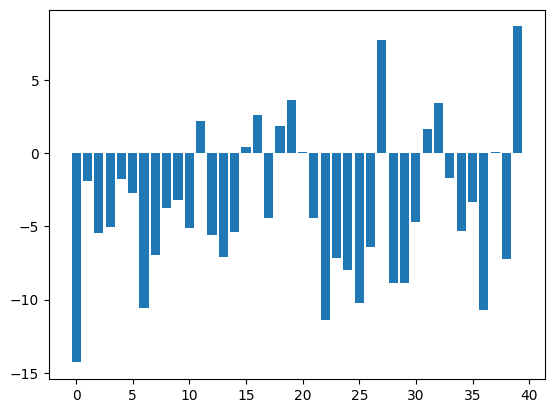

In [53]:
import matplotlib.pyplot as plt
plt.bar(range(40), logits[error_indices[0]])

In [20]:
drop_key1, drop_key2, drop_key3, drop_key4 = jax.random.split(jax.random.PRNGKey(0), 4)

encoder_embeddings = state.apply_fn(
    variables={"params": state.params},
    inputs=examples,
    deterministic=False,
    pad_mask=None,
    rngs={"dropout": drop_key1},
    method=model.encode,
)

cot_start_token = 40
cot_tokens = jnp.concatenate(
    [jnp.full((cots.shape[0], 1), cot_start_token), cots], axis=1
)
cot_labels = jnp.concatenate(
    [cots, jnp.full((cots.shape[0], 1), cot_start_token)], axis=1
)
cot_logits = state.apply_fn(
    variables={"params": state.params},
    cot_tokens=cot_tokens,
    encoder_embeddings=jax.lax.stop_gradient(encoder_embeddings),
    deterministic=False,
    pad_mask=None,
    rngs={"dropout": drop_key2},
    method=model.generate_cot_logits_from_encoder_embeddings,
)
cot_tokens = cots

logits = state.apply_fn(
    variables={"params": state.params},
    encoder_embeddings=encoder_embeddings,
    cot_tokens=cot_tokens,
    deterministic=False,
    encoder_pad_mask=None,
    cot_pad_mask=None,
    rngs={"dropout": drop_key4},
    method=model.decode,
)

In [29]:
cot_tokens[error_indices]

Array([[29, 15],
       [ 2, 14]], dtype=int32)

In [28]:
logits[error_indices].argmax(axis=-1)

Array([39, 29], dtype=int32)

<BarContainer object of 40 artists>

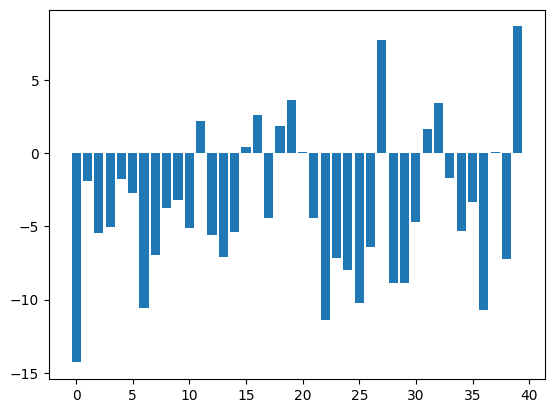

In [52]:
plt.bar(range(40), logits[error_indices[0]])

In [36]:
sampled_cot_tokens, sampled_logits = state.apply_fn(
    variables={"params": state.params},
    encoder_embeddings=encoder_embeddings,
    deterministic=False,
    cot_key=jax.random.PRNGKey(0),
    pad_mask=None,
    rngs={"dropout": drop_key3},
    method=model.cot_module_call,
)
sampled_cot_tokens[error_indices]

Array([[29, 15],
       [ 2, 14]], dtype=int32)

In [44]:
sampled_logits[error_indices[0], 0, :].shape

(40,)

<BarContainer object of 40 artists>

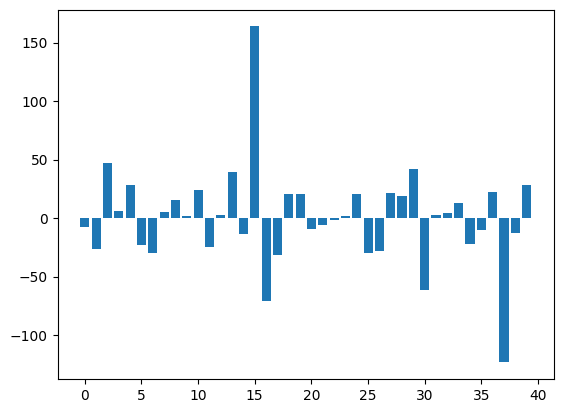

In [50]:
plt.bar(range(40), sampled_logits[error_indices[0], 1, :])